# Best Lags, grid search hyperparams

In [40]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search ---
print("Configurando o Grid Search para o LightGBM...")

lgb_model = lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42)
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [20],
    'max_depth': [-1],
    'reg_alpha': [0.5],
    'reg_lambda': [0.02]
}

"""param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Melhores Hiperparâmetros Encontrados ---
{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0}

Melhor MAE na Validação Cruzada: 0.0495

Avaliando o melhor modelo no conjunto de teste final...

MAE Final no Conjunto de Teste: 0.0230
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Melhores Hiperparâmetros Encontrados ---
{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.02}

Melhor MAE na Validação Cruzada: 0.0497

Avaliando o melhor modelo no conjunto de teste final...

MAE Final no Conjunto de Teste: 0.0230
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

"""

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros... Isso pode demorar.")
start_time = time.time()

# #############################################################################
# CORREÇÃO APLICADA AQUI
# Adicionamos o 'eval_set' ao fit_params para que o callback saiba o que monitorar.
# #############################################################################
fit_params = {
    "eval_set": [(X_test, y_test)],
    "callbacks": [lgb.early_stopping(150, verbose=False)]
}

grid_search.fit(X_train, y_train, **fit_params)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados ---")
print(grid_search.best_params_)

best_score = -grid_search.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando o melhor modelo no conjunto de teste final...")
best_model = grid_search.best_estimator_
final_forecast = best_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_forecast)

print(f"\nMAE Final no Conjunto de Teste: {final_mae:.4f}")

Configurando o Grid Search para o LightGBM...
Iniciando a busca pelos melhores hiperparâmetros... Isso pode demorar.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0.02; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0.02; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0.02; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0.02; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0.02; total time=   0.6s
Grid Search concluído em 4.03 segundos.

--- Melhores Hiperparâmetros Encontrados ---
{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.02}

Melhor MAE na Validação Cruzada: 0.0499

Avaliando o melhor modelo no conjunto de teste final...

MAE

# Grid Search XGBoost


In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search para XGBoost ---
print("Configurando o Grid Search para o XGBoost...")

# Modelo base com early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    n_jobs=-1,
    seed=42,
    early_stopping_rounds=100
)

# Grade de hiperparâmetros que vamos testar
param_grid_xgb = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
# Grade de hiperparâmetros que vamos testar
param_grid_xgb = {
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}
# Validação Cruzada específica para Séries Temporais
tscv = TimeSeriesSplit(n_splits=5)

# Objeto do Grid Search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros para o XGBoost... Isso pode demorar.")
start_time = time.time()

# O XGBoost precisa que o eval_set seja passado dentro do .fit() para o early stopping
# O GridSearchCV lida com isso automaticamente ao passar os dados
grid_search_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados para o XGBoost ---")
print(grid_search_xgb.best_params_)

best_score_xgb = -grid_search_xgb.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score_xgb:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando o melhor modelo XGBoost no conjunto de teste final...")
best_model_xgb = grid_search_xgb.best_estimator_
final_forecast_xgb = best_model_xgb.predict(X_test)
final_mae_xgb = mean_absolute_error(y_test, final_forecast_xgb)

print(f"\nMAE Final no Conjunto de Teste (XGBoost Otimizado): {final_mae_xgb:.4f}")

Configurando o Grid Search para o XGBoost...
Iniciando a busca pelos melhores hiperparâmetros para o XGBoost... Isso pode demorar.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, subsample=1.0; total time=   2.1s
Grid Search concluído em 8.17 segundos.

--- Melhores Hiperparâmetros Encontrados para o XGBoost ---
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 1.0}

Melhor MAE na Validação Cruzada: 0.0436

Avaliando o melhor modelo XGBoost no conjunto de teste final...

MAE Final no Conjunto de Test

In [29]:
# --- 8. Visualização Interativa com SuperTree ---

# Certifique-se de que a biblioteca está instalada:
# pip install supertree

from supertree import SuperTree

print("\nGerando visualização interativa com SuperTree...")

# Instanciando o SuperTree com as variáveis do seu projeto
st = SuperTree(
    best_model_xgb,    # 1º: O seu melhor modelo treinado
    X_train,           # 2º: O seu DataFrame de treino
    y_train,           # 3º: A sua Series de treino
    FEATURES,          # 4º: A sua lista com os nomes das features
    TARGET             # 5º: O nome da sua variável alvo ('ph')
)

# Visualiza a terceira árvore (índice 2)
# A biblioteca pode abrir uma janela do navegador ou exibir no notebook, dependendo do ambiente
st.show_tree(which_tree=2)

print("\nVisualização gerada. Verifique a nova janela do seu navegador ou a saída do seu notebook.")


Gerando visualização interativa com SuperTree...


C:\Users\User\anaconda3\envs\doc\Lib\site-packages\supertree\treedata.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data_target[0], str):



Visualização gerada. Verifique a nova janela do seu navegador ou a saída do seu notebook.


In [27]:
# Gera um DataFrame com a importância de cada feature
feature_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importância': best_model_xgb.feature_importances_
}).sort_values(by='Importância', ascending=False)

print(feature_importance.head(10)) # Mostra as 10 features mais importantes

              Feature  Importância
32  ph_rolling_mean_2     0.806328
34  ph_rolling_mean_4     0.086055
4                 orp     0.023664
18           ph_lag_1     0.018462
37   ph_rolling_std_8     0.016096
19           ph_lag_2     0.011389
35   ph_rolling_std_4     0.006241
20           ph_lag_3     0.005690
31          ph_lag_72     0.002687
21           ph_lag_4     0.002256


<Figure size 2000x2000 with 0 Axes>

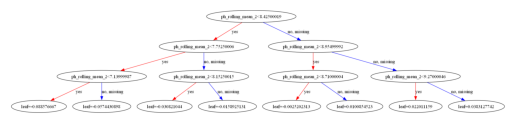

In [25]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))  
plot_tree(best_model_xgb, figsize=(30,20), num_trees=1) 
plt.show()

In [14]:
# --- 8. Visualização Interativa com SuperTree (Versão Final Corrigida) ---

from supertree import SuperTree
import os

print("\nGerando visualização interativa com SuperTree...")

# Instanciando o SuperTree com argumentos posicionais
st = SuperTree(
    best_model_xgb,          # 1º: O modelo
    X_train,                 # 2º: O DataFrame de treino
    y_train,                 # 3º: A Series de treino
    FEATURES,                # 4º: A lista com os nomes das features
    TARGET                   # 5º: O nome da variável alvo (ex: 'ph')
)

# Salva a árvore em um arquivo HTML interativo
tree_index_to_view = 2
output_filename = f'interactive_xgboost_tree_{tree_index_to_view}.html'

# A CORREÇÃO ESTÁ AQUI:
# Passamos o nome do arquivo como o primeiro argumento posicional, sem 'filepath='
st.save_html(output_filename, which_tree=tree_index_to_view)

print(f"\nVisualização interativa da árvore {tree_index_to_view} salva em '{output_filename}'.")
print("Abra este arquivo em seu navegador para explorar a árvore com zoom e detalhes.")


Gerando visualização interativa com SuperTree...
HTML saved to interactive_xgboost_tree_2.html

Visualização interativa da árvore 2 salva em 'interactive_xgboost_tree_2.html'.
Abra este arquivo em seu navegador para explorar a árvore com zoom e detalhes.


In [48]:
# --- 9. Visualização Detalhada com dtreeviz ---

import dtreeviz

tree_index_to_view = 2
print(f"\nGerando e exibindo a visualização da árvore {tree_index_to_view} com dtreeviz...")

# ETAPA 1: Criar o objeto do modelo
viz_model_preparer = dtreeviz.model(
    model=best_model_xgb,
    tree_index=tree_index_to_view,
    X_train=X,
    y_train=y,
    feature_names=FEATURES,
    target_name=TARGET
)

# ETAPA 2: Chamar .view() para exibir a visualização
# Este comando deve abrir a visualização corretamente renderizada
# em uma nova janela do navegador ou diretamente no seu notebook.
visualization = viz_model_preparer.view()

# Para ver no notebook, você também pode simplesmente chamar a variável:
# visualization


Gerando e exibindo a visualização da árvore 2 com dtreeviz...


In [49]:
# --- Certifique-se de que a biblioteca está instalada ---
# pip install supertree

from supertree import SuperTree
import os

print("\nGerando visualização interativa com SuperTree...")

# --- Instanciando o SuperTree com as variáveis do seu projeto ---
st = SuperTree(
    best_model_xgb,    # 1º: O seu melhor modelo treinado
    X_train,           # 2º: O seu DataFrame de treino
    y_train,           # 3º: A sua Series de treino
    FEATURES,          # 4º: A sua lista com os nomes das features
    TARGET             # 5º: O nome da sua variável alvo ('ph')
)

# --- Visualiza a terceira árvore (índice 2) ---
# A biblioteca pode abrir uma janela do navegador ou exibir no notebook
st.show_tree(which_tree=2)

# --- Salva a mesma árvore em um arquivo HTML interativo ---
output_filename = 'interactive_xgboost_tree_2.html'
st.save_html(filepath=output_filename, which_tree=2)
print(f"Árvore interativa salva como '{output_filename}'.")


Gerando visualização interativa com SuperTree...


C:\Users\User\anaconda3\envs\doc\Lib\site-packages\supertree\treedata.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


TypeError: SuperTree.save_html() got an unexpected keyword argument 'filepath'

# Grid search DEcision Tree

In [57]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search para Decision Tree ---
print("Configurando o Grid Search para a Decision Tree...")

# Modelo base
dt_model = DecisionTreeRegressor(random_state=42)

# Grade de hiperparâmetros que vamos testar
param_grid_dt = {
    'max_depth': [10, 20, None], # None significa sem limite
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['squared_error', 'absolute_error']
}

# Validação Cruzada específica para Séries Temporais
tscv = TimeSeriesSplit(n_splits=5)

# Objeto do Grid Search
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros para a Decision Tree... Isso pode demorar.")
start_time = time.time()

grid_search_dt.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados para a Decision Tree ---")
print(grid_search_dt.best_params_)

best_score_dt = -grid_search_dt.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score_dt:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando a melhor Decision Tree no conjunto de teste final...")
best_model_dt = grid_search_dt.best_estimator_
final_forecast_dt = best_model_dt.predict(X_test)
final_mae_dt = mean_absolute_error(y_test, final_forecast_dt)

print(f"\nMAE Final no Conjunto de Teste (Decision Tree Otimizada): {final_mae_dt:.4f}")

Configurando o Grid Search para a Decision Tree...
Iniciando a busca pelos melhores hiperparâmetros para a Decision Tree... Isso pode demorar.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max